## Compare Typhon actions & energy with a list of other dwarfs

Note: [units in galpy](https://docs.galpy.org/en/v1.9.0/getting_started.html#units-in-galpy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from astropy import table, units
from astropy.io import fits, ascii

from galpy.orbit import Orbit
from galpy.util.conversion import get_physical
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf
from galpy.potential.mwpotentials import McMillan17

from plot_functions import *
plt.rcParams.update(params)

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# Boo III 6D
RA_BOO3 = 209.3     # deg  (from Grillmair 2009)
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc  (from Carlin 2018)
PMRA_BOO3 = -1.16   # mas yr^-1  (from Part 1 of this work)
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 191.31   # km s^-1

# Uncertainties (no value for positions)
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 0.75

In [3]:
with fits.open('typhoon_in_gaia_dr3.fits') as hdu_list:
    typhon_data = table.Table(hdu_list[1].data)

In [4]:
typhon_data['dist_kpc'] = typhon_data['dist_by_parallax'] / 1000

In [35]:
typhon_stars = Orbit(np.column_stack([typhon_data['ra'], typhon_data['dec'], 
                                      typhon_data['dist_kpc'], typhon_data['pmra'], 
                                      typhon_data['pmdec'], typhon_data['radial_velocity']]), 
                     radec=True, **get_physical(McMillan17))

typhon_actions = [typhon_stars.jp(pot=McMillan17),
                  typhon_stars.jr(pot=McMillan17),
                  typhon_stars.jz(pot=McMillan17)]
typhon_energies = typhon_stars.E(pot=McMillan17)

typhon_actions2 = [typhon_stars.jp(pot=MWPotential2014),
                  typhon_stars.jr(pot=MWPotential2014),
                  typhon_stars.jz(pot=MWPotential2014)]
typhon_energies2 = typhon_stars.E(pot=MWPotential2014)

To re-create the same plot from Anya's work

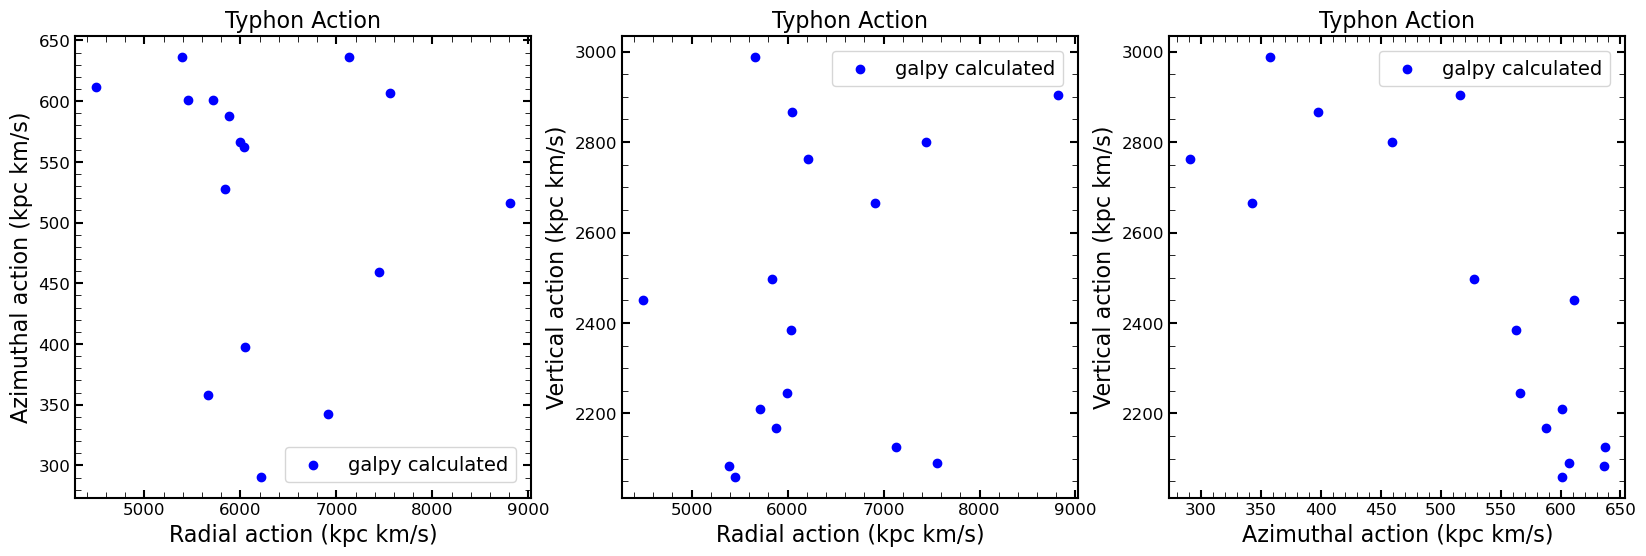

In [6]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(131)
ax1.scatter(typhon_actions[1], typhon_actions[0], c='blue', label='galpy calculated')
ax1.set_xlabel('Radial action (kpc km/s)')
ax1.set_ylabel('Azimuthal action (kpc km/s)')
ax1.set_title('Typhon Action')
ax1.legend()

ax2 = fig.add_subplot(132)
ax2.scatter(typhon_actions[1], typhon_actions[2], c='blue', label='galpy calculated')
ax2.set_xlabel('Radial action (kpc km/s)')
ax2.set_ylabel('Vertical action (kpc km/s)')
ax2.set_title('Typhon Action')
ax2.legend()

ax3 = fig.add_subplot(133)
ax3.scatter(typhon_actions[0], typhon_actions[2], c='blue', label='galpy calculated')
ax3.set_xlabel('Azimuthal action (kpc km/s)')
ax3.set_ylabel('Vertical action (kpc km/s)')
ax3.set_title('Typhon Action')
ax3.legend()
plt.show()

### Prepare all dwarfs

In [7]:
# Note: table2, the proper motion table, is missing data for Cetus III and Virgo I
# So we don't have them in this analysis
table1 = ascii.read('typhon-related-data/dwarfs-info-pace-et-al-2022.txt', delimiter='\t')
table2 = ascii.read('typhon-related-data/dwarfs-pm-pace-et-al-2022.txt', delimiter='\t')

for i in range(len(table1)):
    full_name = table1['Name'][i]
    table1['Name'][i] = full_name.split('(')[0]
    
dwarfs = table.join(table1, table2, keys=['Name'])

# And now remove the galaxies without rv
dwarfs = dwarfs[dwarfs['v _los'].mask == False]

dwarfs.rename_column('R.A.', 'ra')
dwarfs.rename_column('decl.', 'dec')

In [8]:
dwarfs['dist'] = np.nan
dwarfs['dist_err'] = np.nan
dwarfs['rv'] = np.nan
dwarfs['rv_err'] = np.nan

for i in range(len(dwarfs)):
    string = dwarfs['d'][i]
    parts = string.split(' +or- ')
    dwarfs['dist'][i] = float(parts[0])
    dwarfs['dist_err'][i] = float(parts[1])
    
    string2 = dwarfs['v _los'][i]
    parts2 = string2.split(' +or- ')
    dwarfs['rv'][i] = float(parts2[0])
    dwarfs['rv_err'][i] = float(parts2[1])

In [9]:
import re

dwarfs['pmra'] = np.nan
dwarfs['pmra_err'] = np.nan
dwarfs['pmdec'] = np.nan
dwarfs['pmdec_err'] = np.nan

for i in range(len(dwarfs)):
    string1 = dwarfs['${\\overline{{\\mu }_{\\alpha \\star }}}_{F}$'][i]
    string2 = dwarfs['${\\overline{{\\mu }_{\\delta }}}_{F}$'][i]
    
    numbers1 = re.findall(r'-?\d+\.\d+', string1)
    numbers2 = re.findall(r'-?\d+\.\d+', string2)
    
    dwarfs['pmra'][i] = float(numbers1[0])
    dwarfs['pmra_err'][i] = (float(numbers1[2]) - float(numbers1[1])) / 2
    
    dwarfs['pmdec'][i] = float(numbers2[0])
    dwarfs['pmdec_err'][i] = (float(numbers2[2]) - float(numbers2[1])) / 2

In [10]:
dwarfs

Name,ra,dec,r _h,epsilon,theta,d,M _V,v _los,sigma _los,Referances,N,"N _mem,F",${\overline{{\mu }_{\alpha \star }}}_{F}$,${\overline{{\mu }_{\delta }}}_{F}$,"N _mem,G",${\overline{{\mu }_{\alpha \star }}}_{G}$,${\overline{{\mu }_{\delta }}}_{G}$,"sigma _mu,sys",dist,dist_err,rv,rv_err,pmra,pmra_err,pmdec,pmdec_err
str25,float64,float64,str15,str15,str15,str15,str16,str16,str14,str9,int64,str26,str28,str28,str26,str28,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64
Antlia II,143.8868,-36.7673,76.20 +or- 7.20,0.38 +or- 0.08,156.0 +or- 6.0,132.0 +or- 6.0,-9.03 +or- 0.15,290.7 +or- 0.5,5.71 +or- 1.08,a,4889,${558.2}_{-25.2}^{+25.6}$,$-{0.093}_{-0.008}^{+0.008}$,${0.100}_{-0.009}^{+0.009}$,${414.7}_{-24.6}^{+24.9}$,$-{0.090}_{-0.009}^{+0.009}$,${0.100}_{-0.010}^{+0.010}$,0.016,132.0,6.0,290.7,0.5,0.093,0.008,0.1,0.009
Aquarius II,338.4813,-9.3274,5.10 +or- 0.80,0.39 +or- 0.09,121.0 +or- 9.0,107.9 +or- 3.3,-4.36 +or- 0.14,-71.1 +or- 2.5,5.4 +or- 2.15,b,51,${16.3}_{-1.8}^{+1.8}$,$-{0.170}_{-0.119}^{+0.113}$,$-{0.466}_{-0.095}^{+0.096}$,${14.3}_{-1.7}^{+2.1}$,$-{0.183}_{-0.122}^{+0.121}$,$-{0.446}_{-0.096}^{+0.099}$,0.022,107.9,3.3,-71.1,2.5,0.17,0.11599999999999999,0.466,0.0955
Bootes I,210.02,14.5135,9.97 +or- 0.27,0.3 +or- 0.03,6.0 +or- 3.0,66.0 +or- 3.0,-6.02 +or- 0.25,101.8 +or- 0.7,4.6 +or- 0.7,"c,d,e",373,${167.9}_{-3.6}^{+3.5}$,$-{0.385}_{-0.017}^{+0.017}$,$-{1.068}_{-0.013}^{+0.013}$,${170.0}_{-4.5}^{+4.5}$,$-{0.387}_{-0.016}^{+0.017}$,$-{1.064}_{-0.013}^{+0.013}$,0.021,66.0,3.0,101.8,0.7,0.385,0.017,1.068,0.013
Bootes II,209.5141,12.8553,3.17 +or- 0.42,0.25 +or- 0.11,-68.0 +or- 27.0,42.0 +or- 2.0,-2.94 +or- 0.74,-117.0 +or- 5.2,10.5 +or- 7.4,"f,e,g",88,${20.9}_{-0.9}^{+1.0}$,$-{2.426}_{-0.077}^{+0.080}$,$-{0.414}_{-0.061}^{+0.061}$,${20.2}_{-1.0}^{+1.1}$,$-{2.419}_{-0.080}^{+0.078}$,$-{0.413}_{-0.061}^{+0.061}$,0.022,42.0,2.0,-117.0,5.2,2.426,0.0785,0.414,0.061
Bootes III,209.3,26.8,33.03 +or- 2.50,0.33 +or- 0.085,-81.0 +or- 8.0,46.5 +or- 2.0,-5.75 +or- 0.5,197.5 +or- 3.8,14.0 +or- 3.2,"h,i,j",1073,${73.6}_{-5.7}^{+6.0}$,$-{1.176}_{-0.019}^{+0.019}$,$-{0.890}_{-0.015}^{+0.015}$,${90.8}_{-6.8}^{+7.1}$,$-{1.168}_{-0.018}^{+0.018}$,$-{0.890}_{-0.014}^{+0.014}$,0.018,46.5,2.0,197.5,3.8,1.176,0.019,0.89,0.015
Canes Venatici I,202.0091,33.5521,7.12 +or- 0.21,0.44 +or- 0.03,80.0 +or- 2.0,210.0 +or- 6.0,-8.8 +or- 0.06,30.9 +or- 0.6,7.6 +or- 0.4,"l,e,m",322,${122.5}_{-1.4}^{+1.4}$,$-{0.096}_{-0.031}^{+0.030}$,$-{0.116}_{-0.020}^{+0.020}$,${120.5}_{-1.8}^{+1.8}$,$-{0.093}_{-0.030}^{+0.030}$,$-{0.114}_{-0.020}^{+0.020}$,0.021,210.0,6.0,30.9,0.6,0.096,0.0305,0.116,0.02
Canes Venatici II,194.2927,34.3226,1.52 +or- 0.24,0.4 +or- 0.13,9.0 +or- 15.0,160.0 +or- 4.5,-5.17 +or- 0.32,-128.9 +or- 1.2,4.6 +or- 0.8,"n,e,m",15,${11.1}_{-0.6}^{+0.6}$,$-{0.124}_{-0.115}^{+0.117}$,$-{0.254}_{-0.080}^{+0.082}$,${11.8}_{-0.5}^{+1.1}$,$-{0.116}_{-0.109}^{+0.111}$,$-{0.264}_{-0.079}^{+0.080}$,0.023,160.0,4.5,-128.9,1.2,0.124,0.116,0.254,0.081
Carina,100.4065,-50.9593,10.10 +or- 0.10,0.36 +or- 0.01,60.0 +or- 1.0,105.6 +or- 5.4,-9.43 +or- 0.05,222.9 +or- 0.1,6.6 +or- 1.2,"o,e,p",10273,${2043.4}_{-11.4}^{+11.5}$,${0.532}_{-0.006}^{+0.007}$,${0.127}_{-0.006}^{+0.006}$,${1952.8}_{-11.7}^{+11.8}$,${0.534}_{-0.007}^{+0.007}$,${0.124}_{-0.006}^{+0.006}$,0.02,105.6,5.4,222.9,0.1,0.532,0.006500000000000001,0.127,0.006
Carina II,114.1066,-57.9991,8.69 +or- 0.75,0.34 +or- 0.07,170.0 +or- 9.0,37.4 +or- 0.4,-4.57 +or- 0.1,477.2 +or- 1.2,3.4 +or- 1.0,"q,r",5033,${60.4}_{-3.7}^{+3.7}$,${1.885}_{-0.019}^{+0.018}$,${0.133}_{-0.019}^{+0.019}$,--,--,--,0.021,37.4,0.4,477.2,1.2,1.885,0.0185,0.133,0.019


### Set up functions for calculations

In [11]:
from matplotlib.patches import Ellipse
from matplotlib import transforms

def get_dwarf_6D(table_row):
    params = [table_row['ra'], table_row['dec'], table_row['dist'], 
              table_row['pmra'], table_row['pmdec'], table_row['rv']]
    params_error = [0, 0, table_row['dist_err'], 
                    table_row['pmra_err'], table_row['pmdec_err'], table_row['rv_err']]
    
    return params, params_error

def calculate_actions(params_6D, errors_6D, num_of_realizations, potential):
    """Calculate actions given 6D parameters and a potential model. 
    Assuming the given 6D parameters have Gaussian error distribution.

    Return a list of the three action components (each in their own array).
    """
    params = np.random.normal(loc=params_6D, scale=errors_6D, size=(num_of_realizations, 6))
    
    jps, jrs, jzs = [], [], []
    
    for i in range(len(params)):
        print(f"Realizations: {i}/{len(params)}")
        orbit = Orbit(params[i], radec=True, **get_physical(potential))
        jp = orbit.jp(pot=potential, **get_physical(potential))
        jr = orbit.jr(pot=potential, **get_physical(potential))
        jz = orbit.jz(pot=potential, **get_physical(potential))
        jps.append(jp)
        jrs.append(jr)
        jzs.append(jz)
        
    return [np.array(jps), np.array(jrs), np.array(jzs)]

def calculate_energies(params_6D, errors_6D, num_of_realizations, potential):
    """Calculate orbit energy given 6D parameters and a potential model. 
    Assuming the given 6D parameters have Gaussian error distribution.

    Return an array of energy values from the different realizations.
    """
    params = np.random.normal(loc=params_6D, scale=errors_6D, size=(num_of_realizations, 6))
        
    energies = []
    
    for i in range(len(params)):
        print(f"Realizations: {i}/{len(params)}")
        orbit = Orbit(params[i], radec=True, **get_physical(potential))
        energy = orbit.E(pot=potential, **get_physical(potential))
        energies.append(energy)
        
    return np.array(energies)

# Provided by Prof. Li
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    
    See how and why this works: https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    
    This function has made it into the matplotlib examples collection:
    https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    
    Or, once matplotlib 3.1 has been released:
    https://matplotlib.org/gallery/index.html#statistics
    
    I update this gist according to the version there, because thanks to the matplotlib community
    the code has improved quite a bit.
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs,lw=2)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.median(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.median(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Using McMillan17

In [12]:
from galpy.actionAngle import UnboundError

This code is used to compute actions for all dwarfs.
```python
# key : value 
# 'Dwarf Name' : [jps, jrs, jzs]
dwarfs_actions = {}

for i in range(len(dwarfs)):
    print(f"Dwarf: {i}/{len(dwarfs)}")
    params, params_err = get_dwarf_6D(dwarfs[i])
    
    try:
        dwarfs_actions[dwarfs[i]['Name']] = calculate_actions(params, params_err, 100, McMillan17)
    except UnboundError:
        print(dwarfs[i]['Name'] + 'orbit unbound. Skipping.')
```

```python
# key : value 
# 'Dwarf Name' : array of energies
dwarfs_energies = {}

for i in range(len(dwarfs)):
    print(f"Dwarf: {i}/{len(dwarfs)}")
    params, params_err = get_dwarf_6D(dwarfs[i])
    
    try:
        dwarfs_energies[dwarfs[i]['Name']] = calculate_energies(params, params_err, 100, McMillan17)
    except UnboundError:
        print(dwarfs[i]['Name'] + 'orbit unbound. Skipping.')
```

We've saved those actions and energies already, so here we load them in.

In [13]:
import pickle

with open('typhon-related-data/dwarfs_actions_McMillan17.obj', 'rb') as fileObj:
    dwarfs_actions = pickle.load(fileObj)

with open('typhon-related-data/dwarfs_energies_McMillan17.obj', 'rb') as fileObj:
    dwarfs_energies = pickle.load(fileObj)

When using McMillan17 potential, some orbits are unbound so the actions cannot be calculated.

But the energies are fine, so we computed some energies for dwarfs that don't have actions ready. So we only keep the ones with both the actions and the energies.

In [14]:
# Remove the unmatched keys from dwarfs_energies
actions_keys = set(dwarfs_actions.keys())
energies_keys = set(dwarfs_energies.keys())
extra_keys = energies_keys - actions_keys

for key in extra_keys:
    del dwarfs_energies[key]

### Using MWPotential2014

```python
# key : value 
# 'Dwarf Name' : [jps, jrs, jzs]
dwarfs_actions2 = {}

for i in range(len(dwarfs)):
    print(f"Dwarf: {i}/{len(dwarfs)}")
    params, params_err = get_dwarf_6D(dwarfs[i])
    
    try:
        dwarfs_actions2[dwarfs[i]['Name']] = calculate_actions(params, params_err, 100, MWPotential2014)
    except UnboundError:
        print(dwarfs[i]['Name'] + 'orbit unbound. Skipping.')
```

```python
# key : value 
# 'Dwarf Name' : array of energies
dwarfs_energies2 = {}

for i in range(len(dwarfs)):
    print(f"Dwarf: {i}/{len(dwarfs)}")
    params, params_err = get_dwarf_6D(dwarfs[i])

    try:
        dwarfs_energies2[dwarfs[i]['Name']] = calculate_energies(params, params_err, 100, MWPotential2014)
    except UnboundError:
        print(dwarfs[i]['Name'] + 'orbit unbound. Skipping.')
```

In [26]:
with open('typhon-related-data/dwarfs_actions_MWP2014.obj', 'rb') as fileObj:
    dwarfs_actions2 = pickle.load(fileObj)

with open('typhon-related-data/dwarfs_energies_MWP2014.obj', 'rb') as fileObj:
    dwarfs_energies2 = pickle.load(fileObj)

## Compute actions and energy for Boo III

```python
# McMillan17
booIII_actions = calculate_actions([RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3], 
                                   [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3], 
                                   100, McMillan17)
booIII_energies = calculate_energies([RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3], 
                                     [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3], 
                                     100, McMillan17)
# MWPotential2014
booIII_actions2 = calculate_actions([RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3], 
                                   [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3], 
                                   100, MWPotential2014)
booIII_energies2 = calculate_energies([RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3], 
                                     [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3], 
                                     100, MWPotential2014)
```

In [17]:
with open('typhon-related-data/booIII_actions_McMillan17.obj', 'rb') as fileObj:
    booIII_actions = pickle.load(fileObj)

with open('typhon-related-data/booIII_energies_McMillan17.obj', 'rb') as fileObj:
    booIII_energies = pickle.load(fileObj)
    
with open('typhon-related-data/booIII_actions_MWP2014.obj', 'rb') as fileObj:
    booIII_actions2 = pickle.load(fileObj)

with open('typhon-related-data/booIII_energies_MWP2014.obj', 'rb') as fileObj:
    booIII_energies2 = pickle.load(fileObj)

## Plot: Using McMillan17

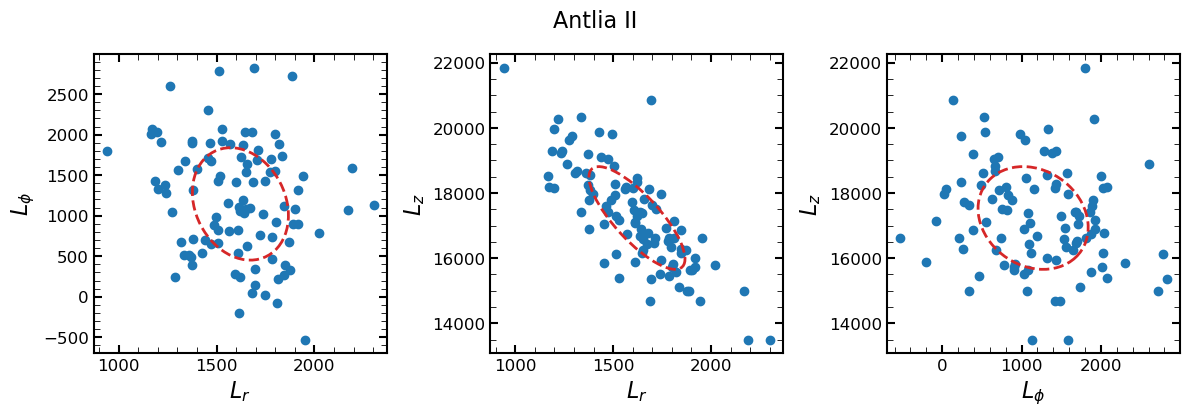

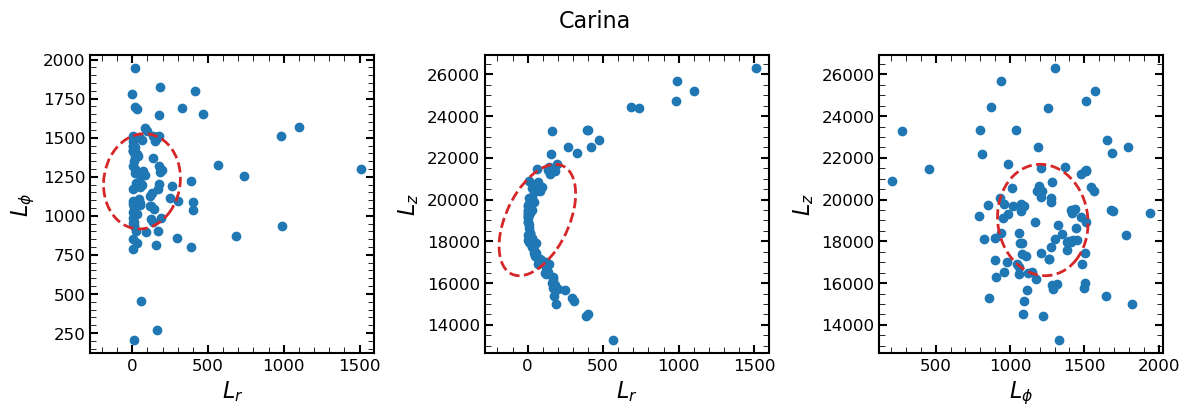

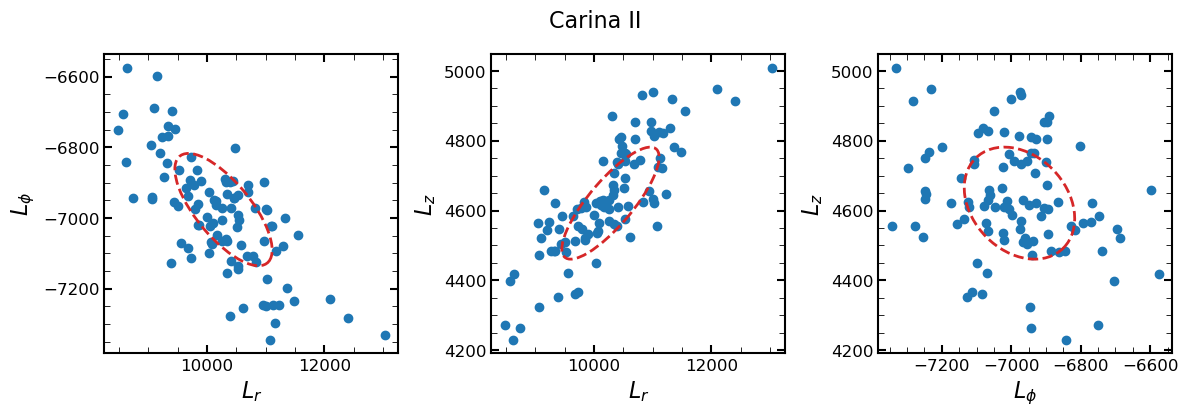

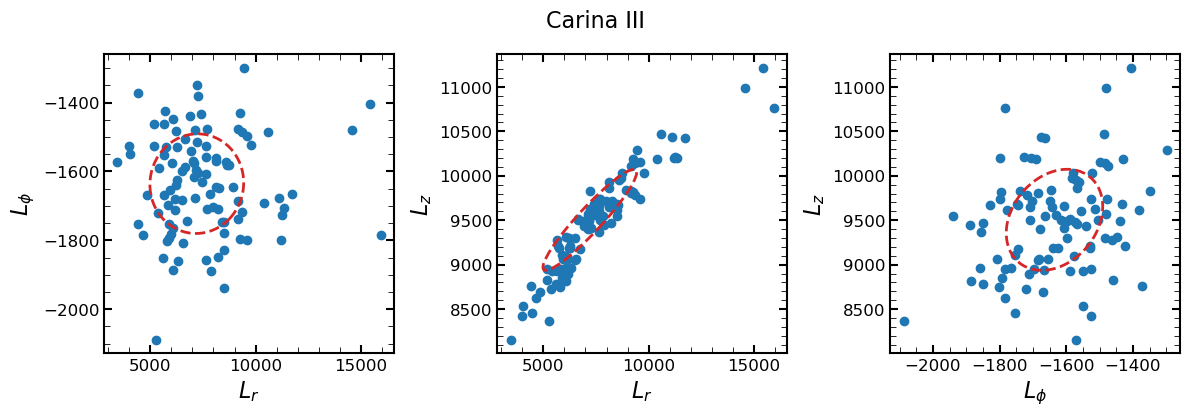

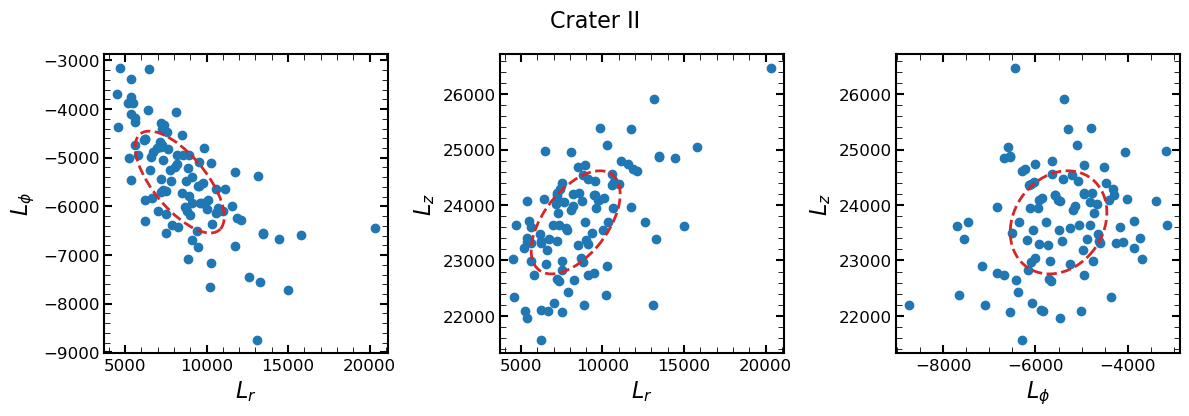

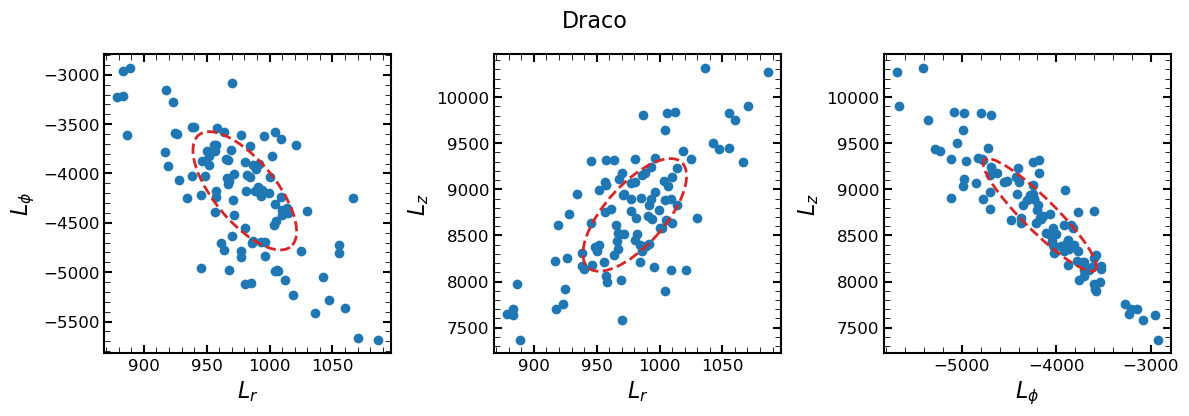

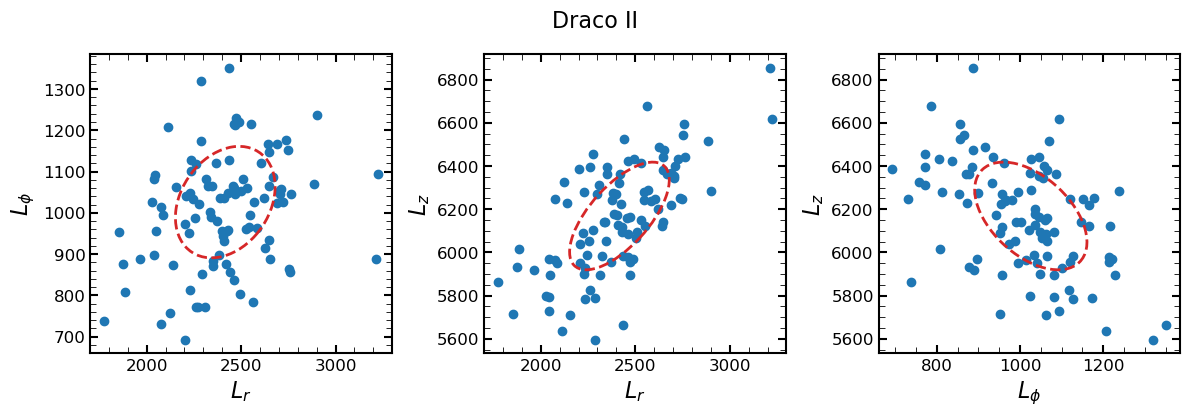

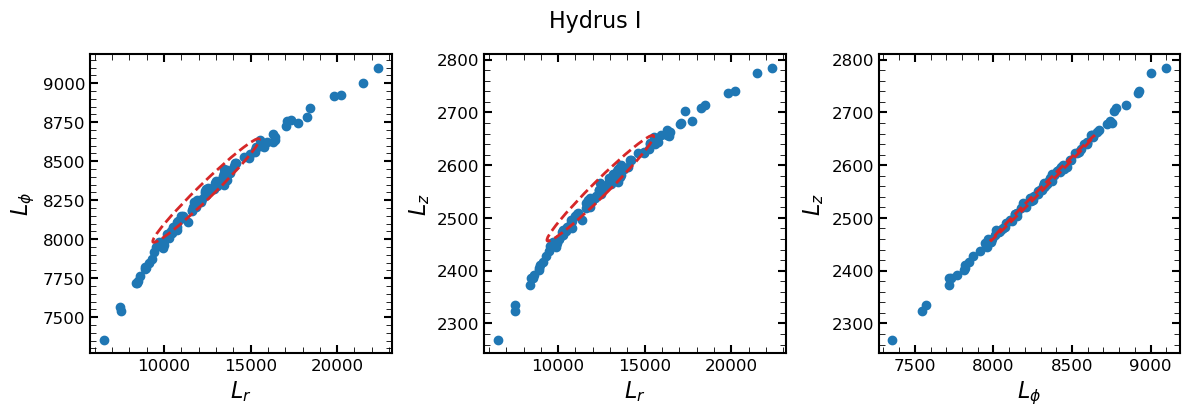

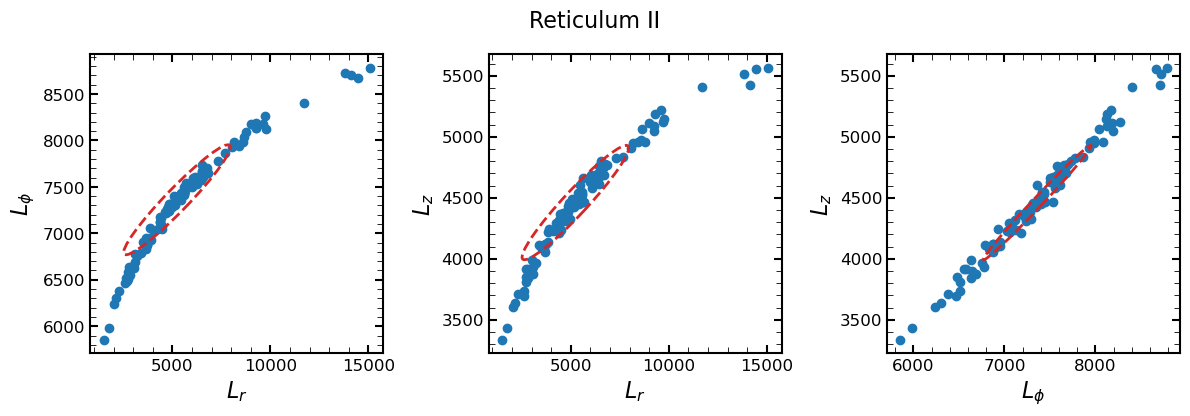

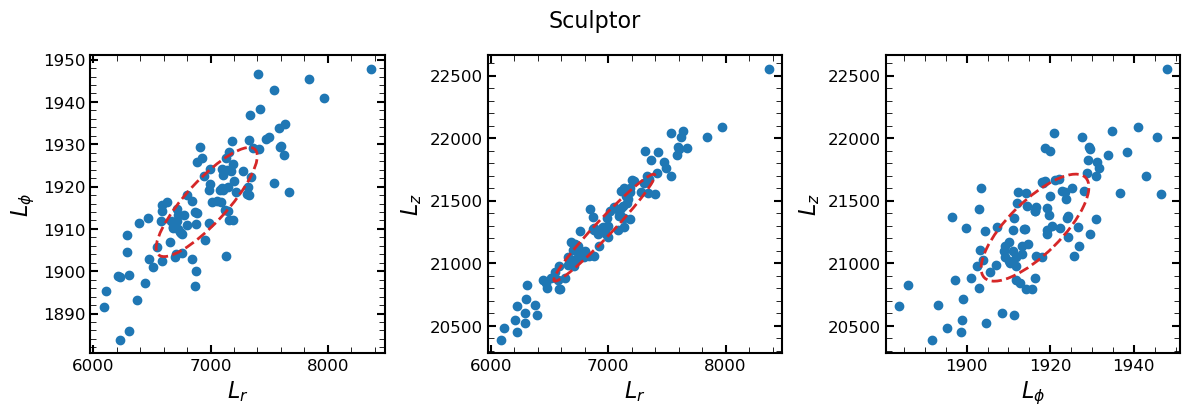

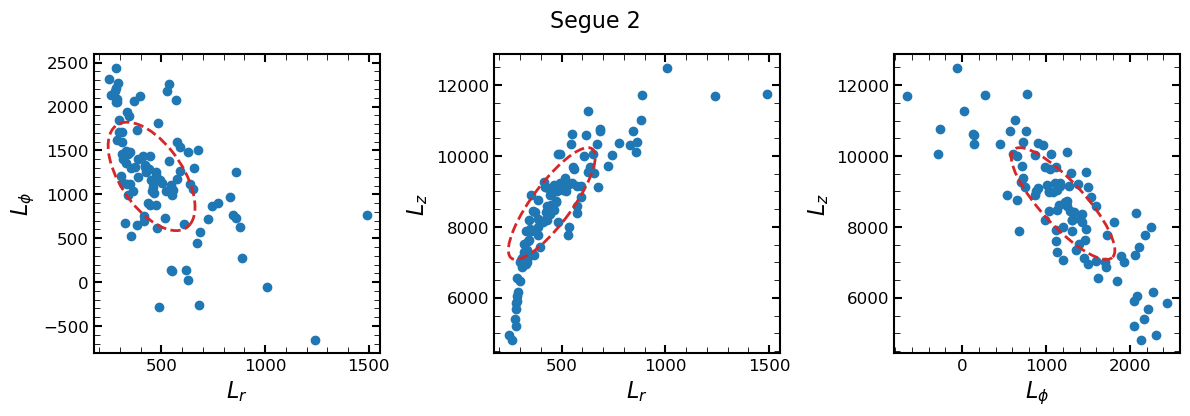

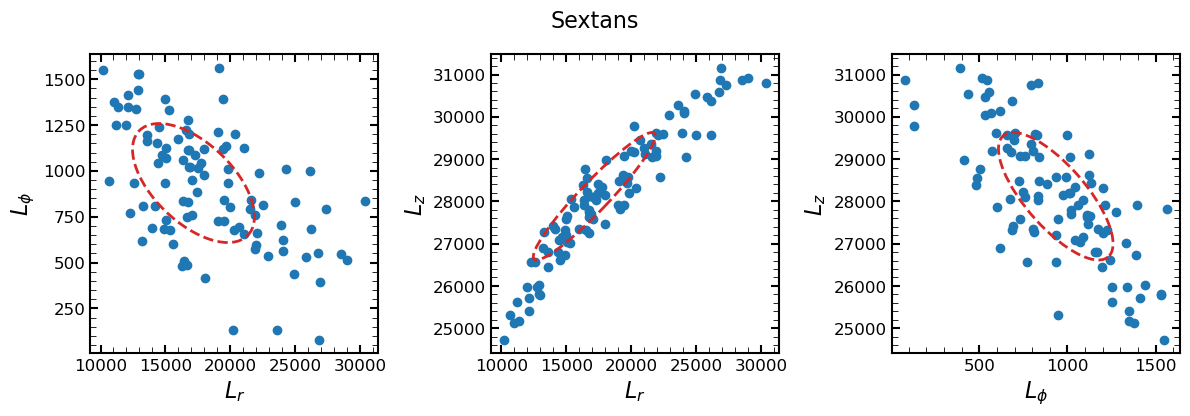

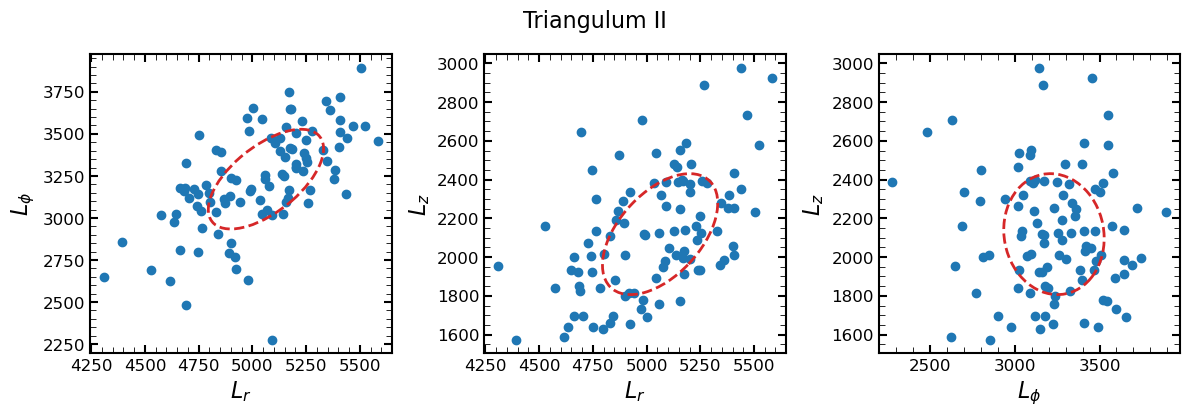

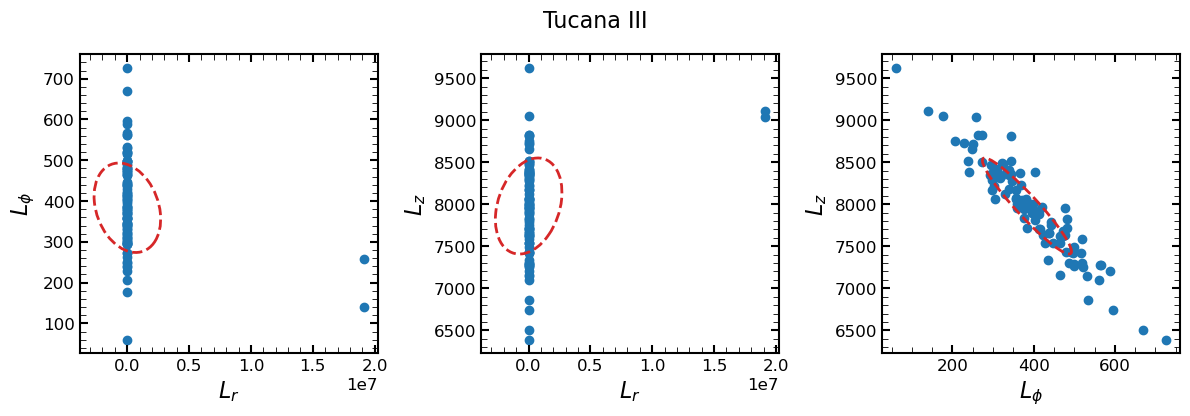

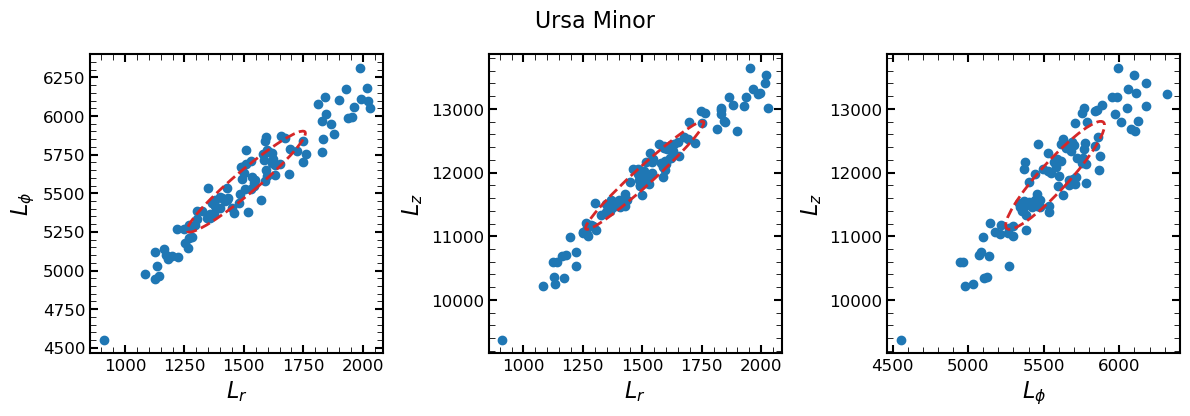

In [16]:
for name in dwarfs_actions.keys():
    fig, ax = plt.subplots(1, 3, figsize=(12, 4.2))

    ax[0].scatter(dwarfs_actions[name][1], dwarfs_actions[name][0])
    confidence_ellipse(dwarfs_actions[name][1], dwarfs_actions[name][0], ax[0], n_std=1, edgecolor='tab:red', ls='--')
    ax[0].set_xlabel(r'$L_r$')
    ax[0].set_ylabel(r'$L_\phi$')

    ax[1].scatter(dwarfs_actions[name][1], dwarfs_actions[name][2])
    confidence_ellipse(dwarfs_actions[name][1], dwarfs_actions[name][2], ax[1], n_std=1, edgecolor='tab:red', ls='--')
    ax[1].set_xlabel(r'$L_r$')
    ax[1].set_ylabel(r'$L_z$')

    ax[2].scatter(dwarfs_actions[name][0], dwarfs_actions[name][2])
    confidence_ellipse(dwarfs_actions[name][0], dwarfs_actions[name][2], ax[2], n_std=1, edgecolor='tab:red', ls='--')
    ax[2].set_xlabel(r'$L_\phi$')
    ax[2].set_ylabel(r'$L_z$')

    fig.suptitle(name)
    plt.tight_layout()
    plt.show()

In [19]:
colours_M17 = ['b', 'lightgreen', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
colours_MW2014 = [
    'b',           # blue
    'g',           # green
    'r',           # red
    'c',           # cyan
    'm',           # magenta
    'y',           # yellow
    'k',           # black
    'tab:blue',    # tab blue
    'tab:orange',  # tab orange
    'tab:green',   # tab green
    'tab:red',     # tab red
    'tab:purple',  # tab purple
    'tab:brown',   # tab brown
    'tab:pink',    # tab pink
    'tab:gray',    # tab gray
    'gold',        # gold
    'lime',        # lime
    'deepskyblue', # deep sky blue
    'orchid',      # orchid
    'sienna',      # sienna
    'plum',        # plum
    'indigo',      # indigo
    'slategray'    # slate gray
]

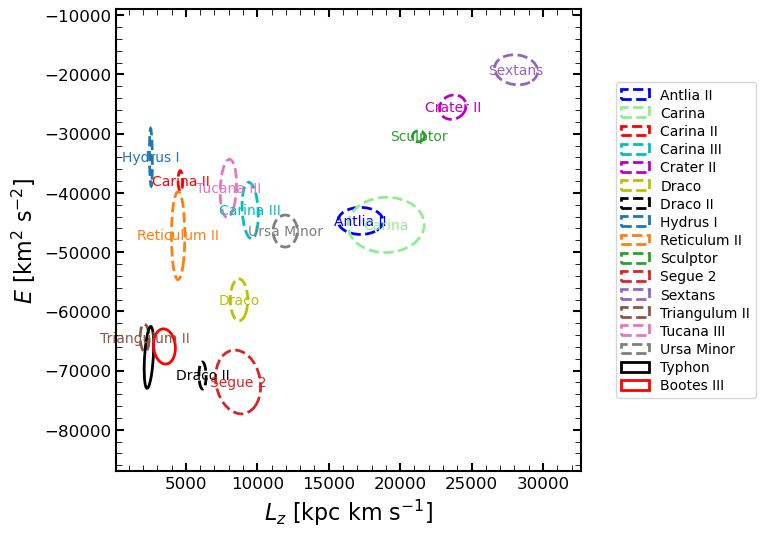

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))

for name, c in zip(dwarfs_actions.keys(), colours_M17):
    ax.scatter(dwarfs_actions[name][2], dwarfs_energies[name], c='none', marker='.')
    confidence_ellipse(dwarfs_actions[name][2], dwarfs_energies[name], ax, n_std=1, edgecolor=c, ls='--', label=name)
    ax.text(np.median(dwarfs_actions[name][2]), np.median(dwarfs_energies[name]), name, ha='center', va='center', c=c)
    
confidence_ellipse(typhon_actions[2], typhon_energies, ax, n_std=1, edgecolor='k', label='Typhon')
confidence_ellipse(booIII_actions[2], booIII_energies, ax, n_std=1, edgecolor='red', label='Bootes III')
ax.set_xlabel(r'$L_z$ [kpc km s$^{-1}$]')
ax.set_ylabel(r'$E$ [km$^{2}$ s$^{-2}$]')
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize=10)

plt.show()

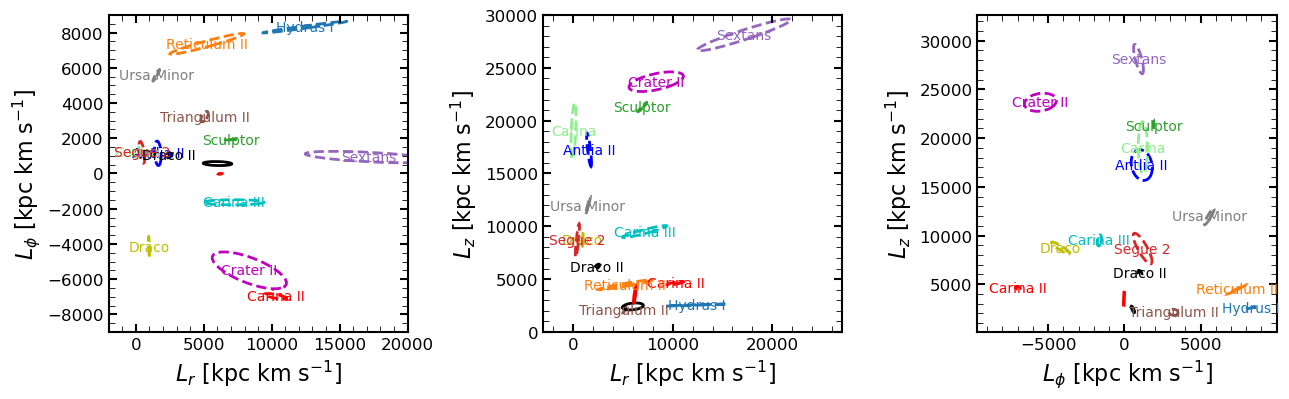

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4.1))

for ax_i, pair in zip([0, 1, 2], [[1, 0], [1, 2], [0, 2]]):
    i, j = pair
    
    for name, c in zip(dwarfs_actions.keys(), colours_M17):
        if name != 'Tucana III':
            ax[ax_i].scatter(dwarfs_actions[name][i], dwarfs_actions[name][j], c='none', marker='.')
            confidence_ellipse(dwarfs_actions[name][i], dwarfs_actions[name][j], ax[ax_i], n_std=1, edgecolor=c, ls='--', label=name)
            ax[ax_i].text(np.median(dwarfs_actions[name][i]), np.median(dwarfs_actions[name][j]), name, ha='center', va='center', c=c)

    confidence_ellipse(typhon_actions[i], typhon_actions[j], ax[ax_i], n_std=1, edgecolor='k', label='Typhon')
    confidence_ellipse(booIII_actions[i], booIII_actions[j], ax[ax_i], n_std=1, edgecolor='red', label='Bootes III')

ax[0].set_xlabel(r'$L_r$ [kpc km s$^{-1}$]')
ax[0].set_ylabel(r'$L_\phi$ [kpc km s$^{-1}$]')
ax[0].set_xlim(-2000, 20000)
ax[0].set_ylim(-9000, 9000)
ax[1].set_xlabel(r'$L_r$ [kpc km s$^{-1}$]')
ax[1].set_ylabel(r'$L_z$ [kpc km s$^{-1}$]')
ax[1].set_xlim(-3000, 27000)
ax[1].set_ylim(0, 30000)
ax[2].set_xlabel(r'$L_\phi$ [kpc km s$^{-1}$]')
ax[2].set_ylabel(r'$L_z$ [kpc km s$^{-1}$]')

plt.tight_layout()
plt.show()

Tucana III has some strange values so it's excluded for now. Didn't dig deeper about what's happening.

In [42]:
dwarfs_actions['Tucana III'][1]

array([1.30913460e+04, 1.32928752e+04, 1.23983455e+04, 9.98747845e+03,
       1.44034279e+04, 1.09661344e+04, 1.34644870e+04, 1.14268750e+04,
       9.79353820e+03, 1.31613101e+04, 1.57387781e+04, 2.13483635e+04,
       1.31986808e+04, 1.08424104e+04, 1.00857707e+04, 1.46722564e+04,
       1.35634134e+04, 1.21976441e+04, 9.26671305e+03, 7.92362111e+03,
       9.83614306e+03, 1.40072635e+04, 8.80588079e+03, 1.04578198e+04,
       1.38999719e+04, 1.17585926e+04, 9.13805459e+03, 1.30975161e+04,
       1.48335804e+04, 1.22629760e+04, 1.00857649e+04, 1.03150027e+04,
       1.47078123e+04, 1.32869152e+04, 1.11376635e+04, 7.42814885e+03,
       1.21863849e+04, 9.96906012e+03, 1.49936626e+04, 9.93472857e+03,
       1.42239284e+04, 1.42476688e+04, 1.05468063e+04, 1.26734023e+04,
       1.23010610e+04, 1.45569185e+04, 1.38221955e+04, 1.32379595e+04,
       1.25523035e+04, 1.00249293e+04, 1.23741610e+04, 1.38920554e+04,
       1.74020052e+04, 1.16964009e+04, 9.06181544e+03, 1.60463876e+04,
      

## Plot: Using MWPotential2014

In [27]:
del dwarfs_actions2['Bootes III']

In [29]:
del dwarfs_energies2['Bootes III']

In [28]:
dwarfs_actions2.keys()

dict_keys(['Antlia II', 'Aquarius II', 'Bootes I', 'Bootes II', 'Canes Venatici I', 'Canes Venatici II', 'Carina', 'Carina II', 'Carina III', 'Columba I', 'Coma Berenices', 'Crater II', 'Draco', 'Draco II', 'Eridanus II', 'Fornax', 'Grus I', 'Grus II', 'Hercules', 'Horologium I', 'Hydra II', 'Hydrus I', 'Leo I', 'Leo II', 'Leo IV', 'Leo V', 'Pegasus III', 'Phoenix II', 'Pisces II', 'Reticulum II', 'Reticulum III', 'Sagittarius II', 'Sculptor', 'Segue 1', 'Segue 2', 'Sextans', 'Triangulum II', 'Tucana II', 'Tucana III', 'Tucana IV', 'Tucana V', 'Ursa Major I', 'Ursa Major II', 'Ursa Minor', 'Willman 1'])

In [33]:
line_styles = ["--"] * 23 + ["-"] * 22

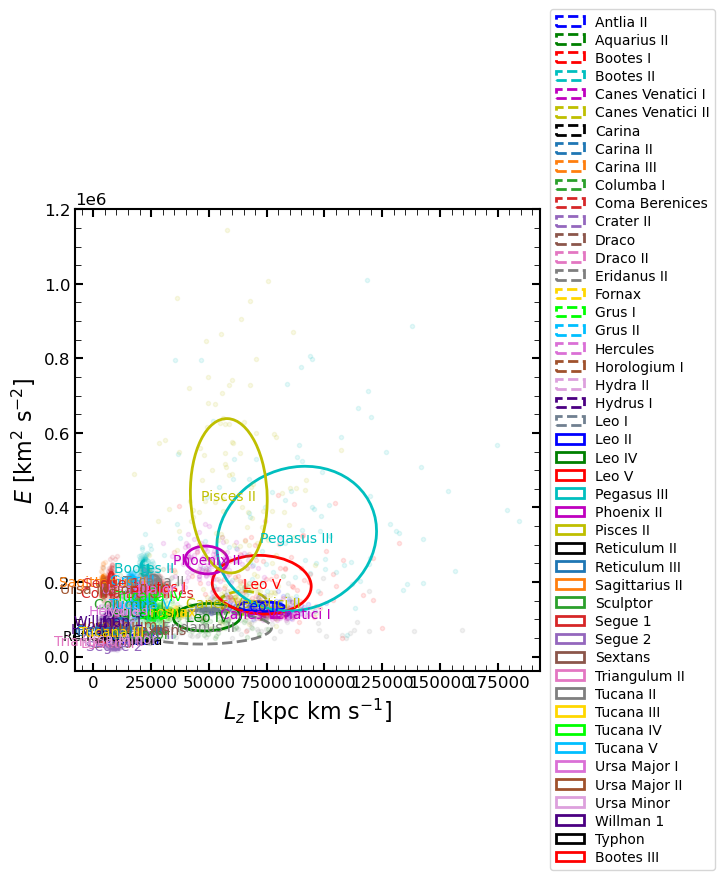

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))

for name, c, ls in zip(dwarfs_actions2.keys(), colours_MW2014 + colours_MW2014[:-1], line_styles):
    ax.scatter(dwarfs_actions2[name][2], dwarfs_energies2[name], c=c, marker='.', alpha=0.1)
    confidence_ellipse(dwarfs_actions2[name][2], dwarfs_energies2[name], ax, n_std=1, edgecolor=c, ls=ls, label=name)
    ax.text(np.median(dwarfs_actions2[name][2]), np.median(dwarfs_energies2[name]), name, ha='center', va='center', c=c)
    
confidence_ellipse(typhon_actions2[2], typhon_energies2, ax, n_std=1, edgecolor='k', label='Typhon')
confidence_ellipse(booIII_actions2[2], booIII_energies2, ax, n_std=1, edgecolor='red', label='Bootes III')
ax.set_xlabel(r'$L_z$ [kpc km s$^{-1}$]')
ax.set_ylabel(r'$E$ [km$^{2}$ s$^{-2}$]')
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize=10)

plt.show()

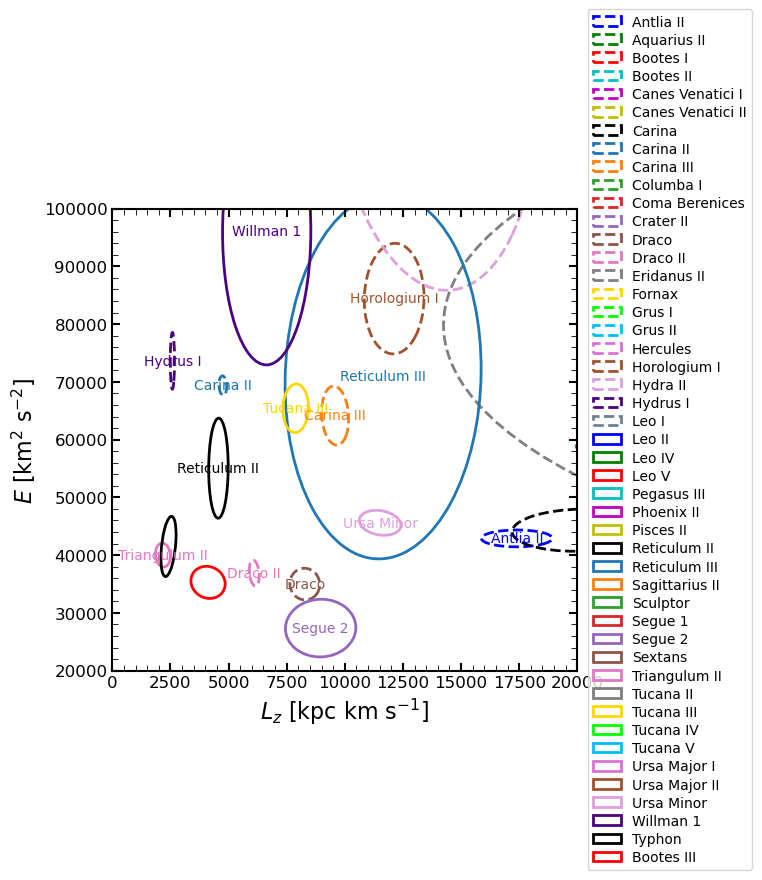

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))

for name, c, ls in zip(dwarfs_actions2.keys(), colours_MW2014 + colours_MW2014[:-1], line_styles):
    ax.scatter(dwarfs_actions2[name][2], dwarfs_energies2[name], c='none', marker='.')
    confidence_ellipse(dwarfs_actions2[name][2], dwarfs_energies2[name], ax, n_std=1, edgecolor=c, ls=ls, label=name)
    
    x = np.median(dwarfs_actions2[name][2])
    y = np.median(dwarfs_energies2[name])
    if x < 2e4 and y < 1e5:
        ax.text(x, y, name, ha='center', va='center', c=c)
    
confidence_ellipse(typhon_actions2[2], typhon_energies2, ax, n_std=1, edgecolor='k', label='Typhon')
confidence_ellipse(booIII_actions2[2], booIII_energies2, ax, n_std=1, edgecolor='red', label='Bootes III')
ax.set_xlabel(r'$L_z$ [kpc km s$^{-1}$]')
ax.set_ylabel(r'$E$ [km$^{2}$ s$^{-2}$]')
ax.set_xlim(0, 2e4)
ax.set_ylim(2e4, 1e5)
ax.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize=10)

plt.show()